In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.io.json._normalize import nested_to_record

%matplotlib inline

## gather data df

In [2]:
username = "lavender"
project_name = "clinical_vs_wiki-new-fixed"
sample_name = "data/num_train_samples"
metric_name = "test/roc_auc"
temporal_metric_name = "test/temporal_roc_auc"
loss_name = "test/loss"
temporal_loss_name = "test/temporal_loss"
pretrained_names = [
    "nyutron (ours)",
    "gatortron-og_new",
    "bio_new",
    "web-wiki_new",
    "random_init_new",
]

In [27]:
import wandb

api = wandb.Api()

# Project is specified by <entity/project-name>
runs = api.runs(f"{username}/{project_name}")
summary_list = []
config_list = []
name_list = []
for run in runs:
    # run.summary are the output key/values like accuracy.
    # We call ._json_dict to omit large files
    summary_list.append(run.summary._json_dict)

    # run.config is the input metrics.
    # We remove special values that start with _.
    conf = nested_to_record(run.config, sep="/")
    config = {k: v for k, v in conf.items() if not k.startswith("_")}
    config_list.append(config)

    # run.name is the name of the run.
    name_list.append(run.name)

import pandas as pd

summary_df = pd.DataFrame.from_records(summary_list)
config_df = pd.DataFrame.from_records(config_list)
name_df = pd.DataFrame({"name": name_list})
data_df = pd.concat([name_df, config_df, summary_df], axis=1)

In [28]:
data_df = data_df[["pretrained", sample_name, metric_name, temporal_metric_name]]

In [29]:
data_df["pretrained"] = data_df["pretrained"].replace(
    {"clinical_new": "nyutron (ours)"}
)
data_df = data_df[data_df.pretrained.isin(pretrained_names)]
data_df.to_csv("raw_data/3b_lms.csv")
data_df = data_df.rename(columns={"pretrained": "pretrained LLM"})

In [17]:
data_df[["pretrained LLM", sample_name]]

,pretrained LLM,data/num_train_samples
0,bio_new,100000
1,web-wiki_new,100000
2,gatortron-og_new,100000
3,gatortron-og_new,362259
4,bio_new,362259
...,...,...
274,clinical,392336
275,clinical,100000
276,clinical,1000
277,clinical,10000


In [18]:
def prep(df):
    df = df.rename(
        columns={
            sample_name: "Number of Train Samples",
            metric_name: "Same-time Test AUROC",
            temporal_metric_name: "Temporal Test AUROC",
            loss_name: "Same-time Test Loss",
            temporal_loss_name: "Temporal Test Loss",
        }
    )
    return df


df_plot = prep(data_df)

In [19]:
import numpy as np

np.unique(np.array(df_plot["pretrained LLM"]))

array(['bio', 'bio_new', 'clinical', 'clinical_large',
       'clinical_large_new', 'gatortron-og', 'gatortron-og_new',
       'nyutron (ours)', 'random_init', 'random_init_new', 'web-wiki',
       'web-wiki_new'], dtype=object)

## Plot combined dfs

In [20]:
df_plot["pretrained LLM"] = pd.Categorical(
    df_plot["pretrained LLM"], categories=pretrained_names, ordered=True
)
df_plot = df_plot.sort_values(by="pretrained LLM")

/tmp/ipykernel_212021/2253318479.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax1 = sns.lineplot(x="Number of Train Samples", y=name,
/tmp/ipykernel_212021/2253318479.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax1 = sns.lineplot(x="Number of Train Samples", y=name,


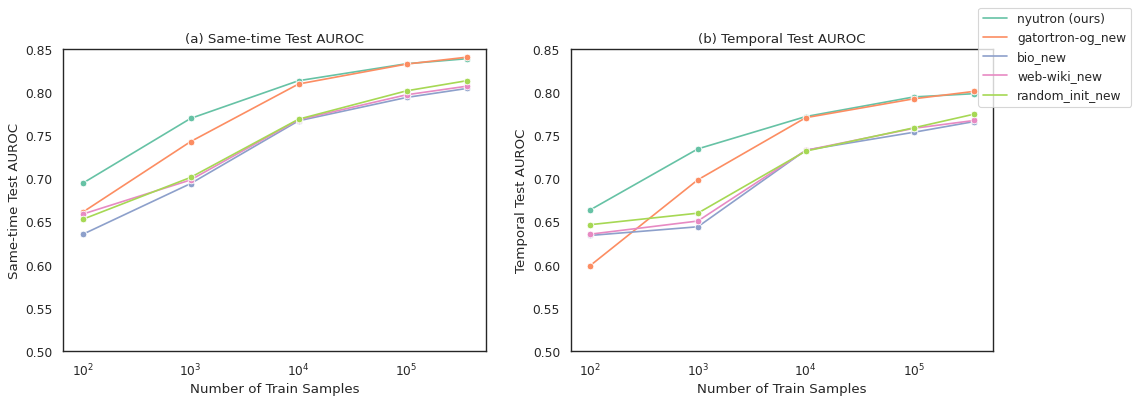

In [21]:
fig = plt.figure(figsize=(15, 5), dpi=80)
save_name = "new_data_eff.png"
sns.set(font_scale=1)
sns.set_style("white")
idx = ["a", "b"]
vals = [metric_name, temporal_metric_name]
plot_name = {
    metric_name: "Same-time Test AUROC",
    temporal_metric_name: "Temporal Test AUROC",
}
sns.color_palette("pastel")

# add subplots
handles = None
labels = None
for i, val in enumerate(vals, 1):
    name = plot_name[val]
    plt.subplot(1, 2, i)
    ax1 = sns.lineplot(
        x="Number of Train Samples",
        y=name,
        hue="pretrained LLM",
        marker="o",
        ci=None,
        estimator=np.median,
        palette=sns.color_palette("Set2", 5),
        data=df_plot,
    )
    ax1.set(xscale="log")
    if handles is None and labels is None:
        handles, labels = ax1.get_legend_handles_labels()
    ax1.get_legend().remove()
    plt.title(f"({idx[i-1]}) {name}")
    plt.ylim((0.5, 0.85))

fig.legend(handles, labels, loc="upper right", ncol=1, bbox_to_anchor=(1.02, 1))
plt.show()
# add subtitle
fig.suptitle("Comparison of Pretrained/Random Models for Readmission Finetuning")

plt.show()
fig.savefig("plots/temporal_and_random_eff.png", dpi=300)

# Start here for cache

/tmp/ipykernel_212021/1318944874.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(x="Number of Train Samples", y="Temporal Test AUROC",


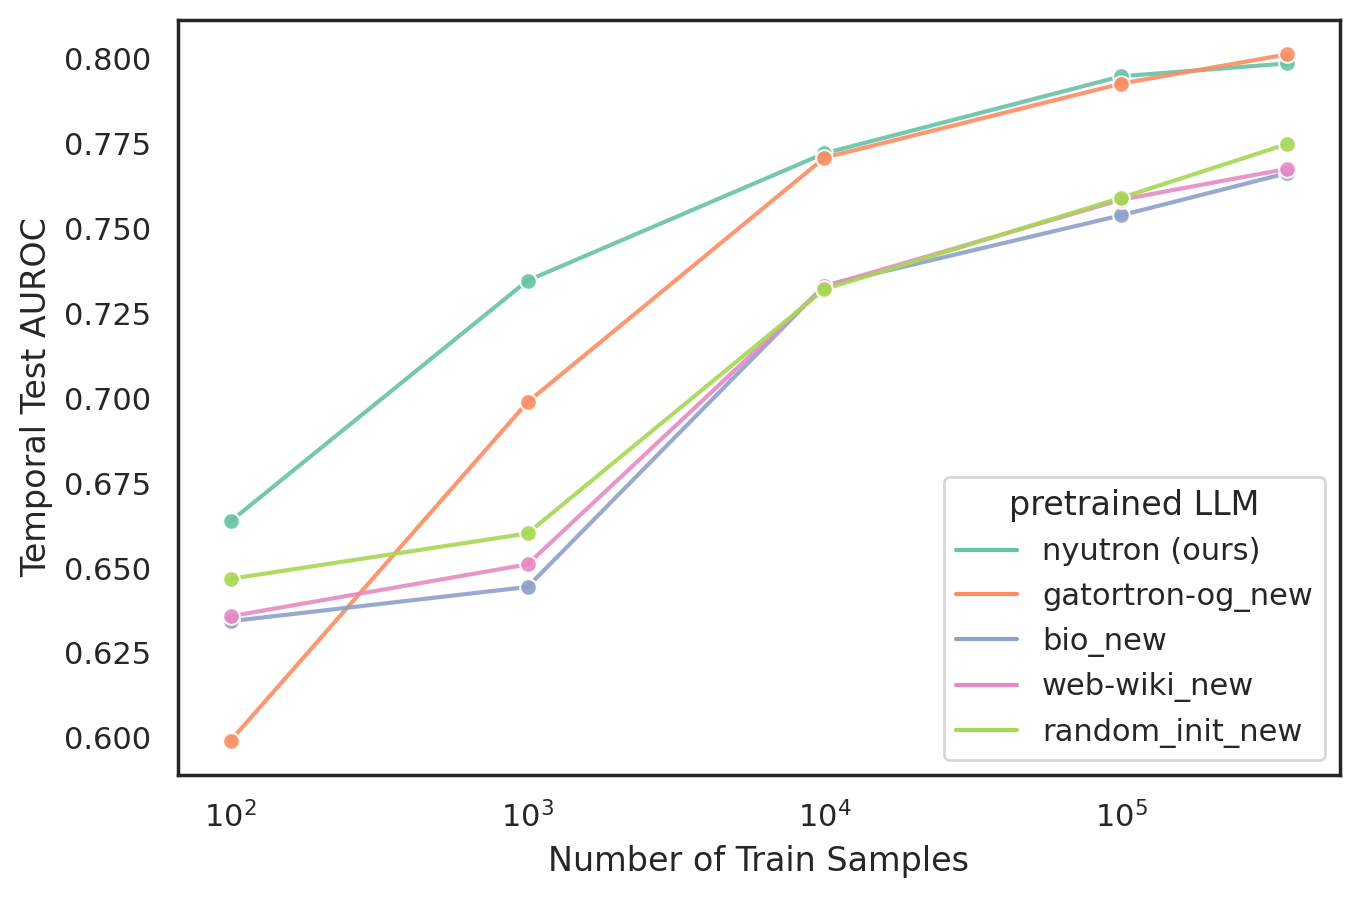

In [22]:
fig = plt.figure(figsize=(7.5, 5), dpi=200)
ax = sns.lineplot(
    x="Number of Train Samples",
    y="Temporal Test AUROC",
    hue="pretrained LLM",
    marker="o",
    err_style="bars",
    alpha=0.9,
    ci=None,
    data=df_plot,
    estimator=np.median,
    palette=sns.color_palette("Set2", 5),
)
ax.set(xscale="log")
plt.savefig("plots/data_eff.png", bbox_inches="tight", dpi=100)